<a href="https://colab.research.google.com/github/jsansao/teic-20231/blob/main/TEIC_Licao17_RNN_Onda_Senoidal_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Previsão de Onda Senoidal com RNN (LSTM)

  Este notebook demonstra como usar uma Rede Neural Recorrente (especificamente, uma LSTM) com TensorFlow e Keras para prever o próximo valor em uma série temporal de onda senoidal.

 O código está dividido nas seguintes etapas:
 1.  **Importações e Geração dos Dados**: Importa as bibliotecas e cria a onda senoidal sintética.
 2.  **Preparação dos Dados**: Converte a série em "janelas" (sequências) para o treinamento.
 3.  **Construção do Modelo**: Define a arquitetura da rede LSTM.
 4.  **Treinamento**: Treina o modelo com os dados.
 5.  **Avaliação e Visualização**: Plota os resultados para ver o desempenho do modelo.


Versão do TensorFlow: 2.19.0
Total de pontos de dados: 1501


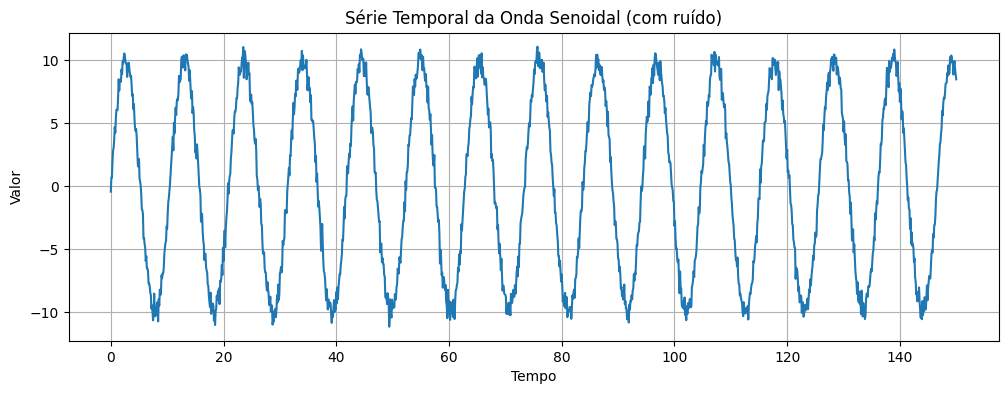

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

print(f"Versão do TensorFlow: {tf.__version__}")

# Criamos 1500 pontos no tempo
# A onda senoidal dará 15 "ciclos" (150 / (2*pi*0.6) ~= 15)
t = np.linspace(0, 150, 1501)
# Criamos a série: uma onda senoidal + um pouco de ruído para tornar mais realista
series = np.sin(t * 0.6) * 10 + np.random.randn(len(t)) * 0.5

print(f"Total de pontos de dados: {len(series)}")

# Plotar os dados para dar uma olhada
plt.figure(figsize=(12, 4))
plt.title("Série Temporal da Onda Senoidal (com ruído)")
plt.plot(t, series)
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

In [8]:


def create_sequences(data, n_steps):
    """
    Converte uma série temporal 1D em um dataset supervisionado para RNNs.
    Entrada: [1, 2, 3, 4, 5, 6, 7] com n_steps = 3
    Saída X:
        [[1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6]]
    Saída y:
        [4, 5, 6, 7]
    """
    X, y = [], []
    for i in range(len(data)):
        # Encontra o fim da sequência
        end_ix = i + n_steps
        # Verifica se estamos dentro dos limites
        if end_ix > len(data) - 1:
            break
        # Gera as janelas de entrada (X) e saída (y)
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Quantos passos no tempo (timesteps) usaremos para prever o futuro?
N_STEPS = 50
# Quantos recursos (features) em cada passo? Apenas 1 (o valor da onda)
N_FEATURES = 1

X, y = create_sequences(series, N_STEPS)

# O Keras espera uma entrada na forma: [samples, timesteps, features]
# Atualmente, nosso X está como [samples, timesteps]. Adicionamos a última dimensão.
X = X.reshape((X.shape[0], X.shape[1], N_FEATURES))

print(f"Formato do X: {X.shape}") # Ex: (1451, 50, 1)
print(f"Formato do y: {y.shape}") # Ex: (1451,)


Formato do X: (1451, 50, 1)
Formato do y: (1451,)


In [9]:
# Usaremos os primeiros 80% dos dados para treino e os últimos 20% para teste.
split_point = int(len(X) * 0.8)

X_train, y_train = X[:split_point], y[:split_point]
X_test, y_test = X[split_point:], y[split_point:]

print(f"Amostras de Treino: {len(X_train)}")
print(f"Amostras de Teste: {len(X_test)}")


Amostras de Treino: 1160
Amostras de Teste: 291


# 4. Construção do Modelo RNN (LSTM)

In [10]:


model = Sequential([
    # Input define o formato de entrada: 50 timesteps, 1 feature
    Input(shape=(N_STEPS, N_FEATURES)),

    # Uma camada LSTM com 50 neurônios.
    # 'tanh' (padrão) é geralmente uma boa ativação para LSTMs.
    LSTM(8, activation='tanh'),

    # Uma camada de saída densa com 1 neurônio (para prever o único valor futuro)
    Dense(1)
])

# Compilamos o modelo.
# 'mse' (Mean Squared Error) é a função de perda padrão para regressão.
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Treinamento do Modelo

In [11]:


print("\nIniciando o treinamento...")

# Treinamos o modelo
# validation_data permite ver o desempenho no conjunto de teste a cada época.
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1
)

print("Treinamento concluído.")


Iniciando o treinamento...
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 43.2641 - val_loss: 43.7294
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 41.6990 - val_loss: 41.7059
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 38.8903 - val_loss: 39.3629
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 36.5404 - val_loss: 36.8072
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 34.2764 - val_loss: 33.9438
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 31.5508 - val_loss: 30.4364
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 27.1678 - val_loss: 27.3067
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 26.0476 - val_loss: 24.7077
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 23.3549 - val_loss: 22.4293
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.6199 - val_loss: 20.3423
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 19.2008 - val_loss: 18.4274
Ep

# 6. Avaliação e Visualização


Gerando visualizações...


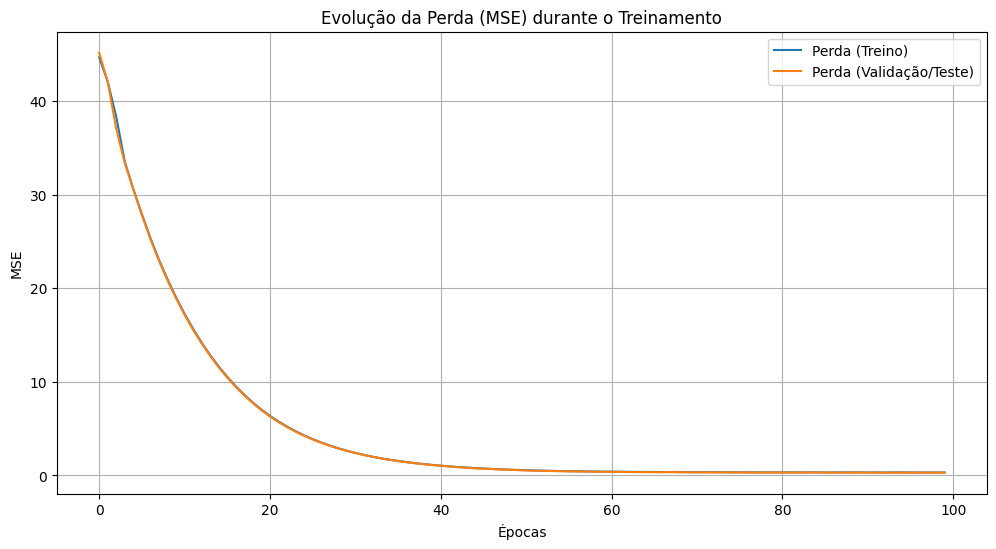

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


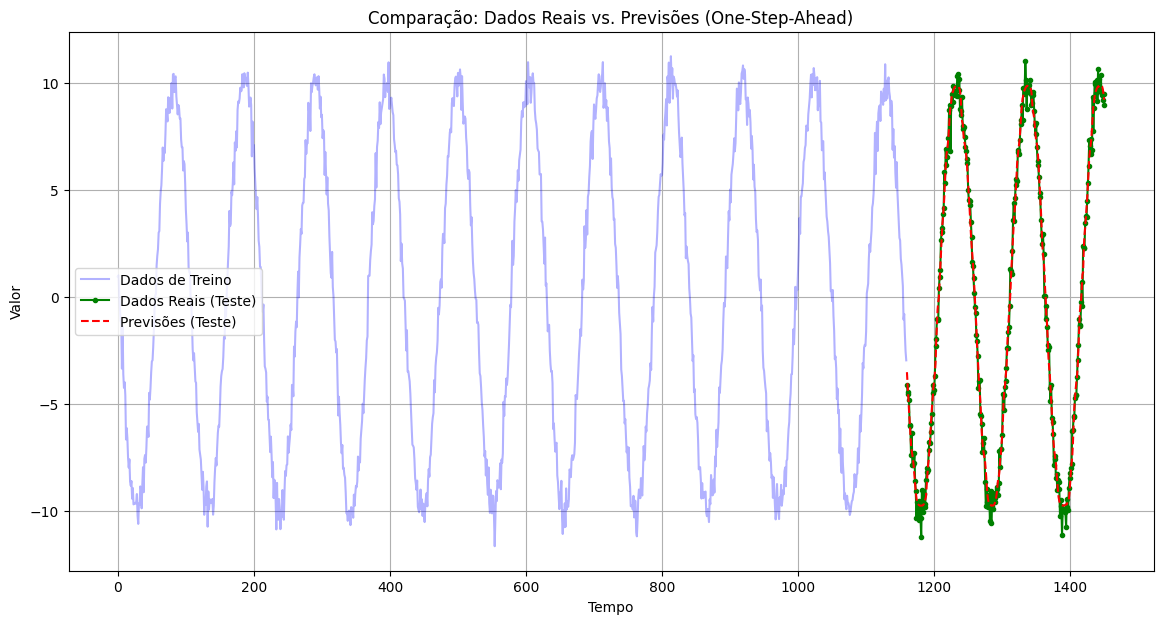

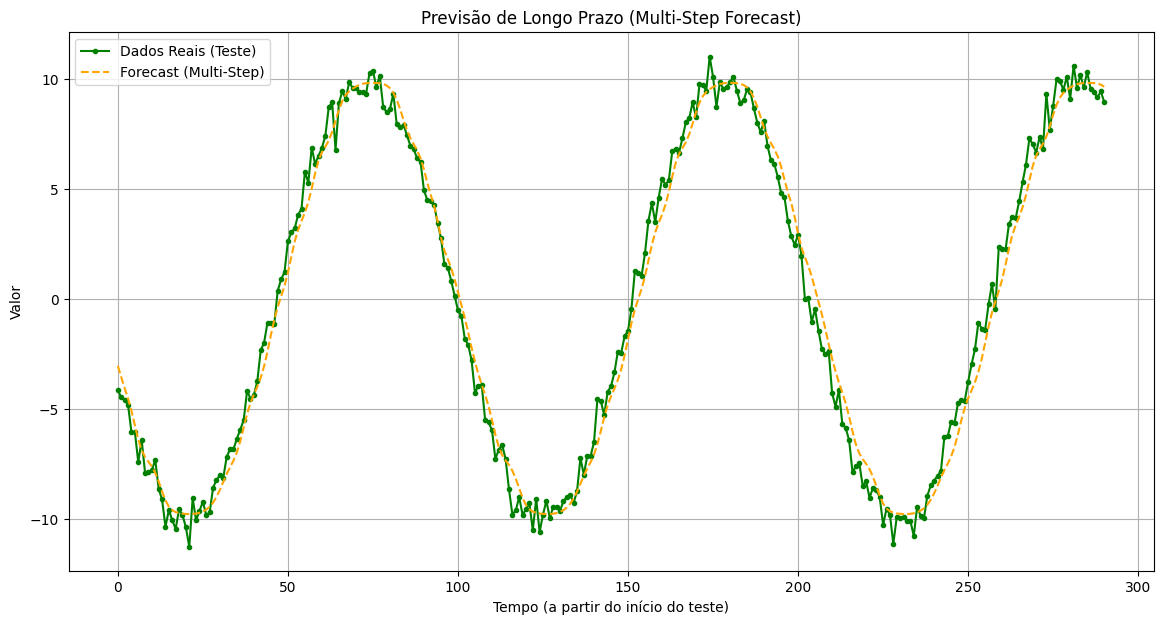


Visualizações concluídas.


In [6]:




print("\nGerando visualizações...")

# Gráfico 1: Perda (Loss) de Treino vs. Validação
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda (Treino)')
plt.plot(history.history['val_loss'], label='Perda (Validação/Teste)')
plt.title('Evolução da Perda (MSE) durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


# Gráfico 2: Previsão "One-Step-Ahead" (Previsão de Validação)
# O modelo usa os dados reais de X_test para prever y_test.
# Isso mostra o quão bem o modelo aprendeu o padrão local.
test_predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
# Plotamos os dados de treino (para contexto)
plt.plot(range(len(y_train)), y_train, label='Dados de Treino', color='blue', alpha=0.3)
# Plotamos os dados reais de teste
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Dados Reais (Teste)', color='green', marker='.')
# Plotamos as previsões do modelo
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Previsões (Teste)', color='red', linestyle='--')
plt.title('Comparação: Dados Reais vs. Previsões (One-Step-Ahead)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


# Gráfico 3: Previsão "Multi-Step-Ahead" (Forecast de Longo Prazo)
# Este é o teste mais difícil.
# Pegamos o último lote de dados de treino e pedimos ao modelo para
# prever o futuro, usando suas próprias previsões como entrada para os próximos passos.

forecast = [] # Lista para armazenar as previsões
# Pega a última sequência dos dados de treino como ponto de partida
current_batch = X_train[-1].reshape((1, N_STEPS, N_FEATURES))

# Itera pelo número de pontos que queremos prever (o tamanho do nosso conjunto de teste)
for i in range(len(y_test)):
    # 1. Faz uma previsão (próximo ponto)
    # Adicionado verbose=0 para não poluir a saída do notebook durante o loop
    current_pred = model.predict(current_batch, verbose=0)[0]

    # 2. Armazena a previsão
    forecast.append(current_pred)

    # 3. Atualiza o 'current_batch'
    # Remove o primeiro valor (o mais antigo)
    # Adiciona o novo valor previsto no final
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)


plt.figure(figsize=(14, 7))
# Plotamos os dados reais de teste
plt.plot(range(len(y_test)), y_test, label='Dados Reais (Teste)', color='green', marker='.')
# Plotamos a previsão "multi-step"
plt.plot(range(len(y_test)), forecast, label='Forecast (Multi-Step)', color='orange', linestyle='--')
plt.title('Previsão de Longo Prazo (Multi-Step Forecast)')
plt.xlabel('Tempo (a partir do início do teste)')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

print("\nVisualizações concluídas.")